# Prediksi Mobil: Random Forest dengan SMOTE
**Alur Pengerjaan:**
1. Persiapan Data
2. K Fold Split Data
3. Ovevrsampling Data
4. Trainn  Random Forest
5. Evaluasi Hasil
6. Prediksi 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE

# Konfigurasi Tampilan
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

In [2]:
# Load Dataset Hasil Clustering
file_path = 'Hasil/Clustered_CarsDataset.csv'
df = pd.read_csv(file_path)

# --- FUNGSI CLEANING (Dicopy dari tahap sebelumnya agar konsisten) ---
def clean_currency(value):
    if pd.isna(value): return 0
    val_str = str(value).replace('$', '').replace(',', '').replace(' ', '')
    if '-' in val_str:
        try:
            low, high = val_str.split('-')
            return (float(low) + float(high)) / 2
        except: return 0
    try: return float(val_str)
    except: return 0

def clean_unit(value):
    if pd.isna(value): return 0
    val_str = str(value).lower()
    for unit in ['cc', 'hp', 'km/h', 'sec', 'nm', 'seconds']:
        val_str = val_str.replace(unit, '')
    if '/' in val_str: val_str = val_str.split('/')[0]
    val_str = val_str.replace(',', '').strip()
    if '-' in val_str:
        try:
            parts = re.findall(r"[\d\.]+", val_str)
            nums = [float(p) for p in parts]
            return sum(nums) / len(nums) if nums else 0
        except: return 0
    match = re.search(r"[\d\.]+", val_str)
    if match: return float(match.group())
    return 0

# Terapkan Cleaning pada Fitur X
features = ['CC/Battery Capacity', 'HorsePower', 'Total Speed', 
            'Performance(0 - 100 )KM/H', 'Cars Prices', 'Torque', 'Seats']

X = df[features].copy()
X['Cars Prices'] = X['Cars Prices'].apply(clean_currency)
X['CC/Battery Capacity'] = X['CC/Battery Capacity'].apply(clean_unit)
X['HorsePower'] = X['HorsePower'].apply(clean_unit)
X['Total Speed'] = X['Total Speed'].apply(clean_unit)
X['Performance(0 - 100 )KM/H'] = X['Performance(0 - 100 )KM/H'].apply(clean_unit)
X['Torque'] = X['Torque'].apply(clean_unit)
X['Seats'] = pd.to_numeric(X['Seats'], errors='coerce').fillna(0)

# Target (Label Cluster)
y = df['Cluster_Label']

# Mapping Nama Cluster (Agar Laporan lebih enak dibaca)
# Sesuaikan mapping ini dengan hasil profiling di notebook sebelumnya
cluster_map = {
    0: 'Economy',
    1: 'Sports',
    2: 'Supercar',
    3: 'Hypercar'
}

print("Persiapan Data Selesai.")
print("Distribusi Kelas Awal:")
print(y.value_counts().sort_index().rename(index=cluster_map))

Persiapan Data Selesai.
Distribusi Kelas Awal:
Cluster_Label
Economy     443
Sports      556
Supercar    213
Hypercar      6
Name: count, dtype: int64


# Train Data

In [3]:
# Inisialisasi
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Mengurangi k_neighbors SMOTE menjadi 1 atau 2 karena Cluster Hypercar sangat sedikit (6 data)
# Jika k_neighbors > jumlah sampel minoritas di training set, SMOTE akan error.
smote = SMOTE(random_state=42, k_neighbors=2) 

fold_scores = []
conf_matrices = []

print(f"Mulai Training dengan {k}-Fold Cross Validation & SMOTE Oversampling...\n")

for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    # 1. Split Data
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # 2. Oversampling (SMOTE) HANYA pada Data Training
    # Ini mencegah data leakage (kebocoran data) dari validasi ke training
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # 3. Latih Model
    rf_model.fit(X_train_resampled, y_train_resampled)
    
    # 4. Prediksi Data Validasi
    y_pred = rf_model.predict(X_val)
    
    # 5. Hitung Metrik
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='weighted')
    prec = precision_score(y_val, y_pred, average='weighted')
    rec = recall_score(y_val, y_pred, average='weighted')
    
    fold_scores.append({
        'Fold': fold + 1,
        'Accuracy': acc,
        'F1-Score': f1,
        'Precision': prec,
        'Recall': rec
    })
    
    # Simpan Confusion Matrix untuk analisis nanti
    cm = confusion_matrix(y_val, y_pred)
    conf_matrices.append(cm)
    
    print(f"✅ Fold {fold+1}: Accuracy = {acc:.4f} | F1-Score = {f1:.4f}")

print("\nTraining Selesai.")

Mulai Training dengan 5-Fold Cross Validation & SMOTE Oversampling...

✅ Fold 1: Accuracy = 0.9795 | F1-Score = 0.9796
✅ Fold 2: Accuracy = 0.9672 | F1-Score = 0.9673
✅ Fold 3: Accuracy = 0.9836 | F1-Score = 0.9836
✅ Fold 4: Accuracy = 0.9465 | F1-Score = 0.9465
✅ Fold 5: Accuracy = 0.9588 | F1-Score = 0.9589

Training Selesai.


RATA-RATA PERFORMA MODEL (5 Folds):
Fold         3.000000
Accuracy     0.967136
F1-Score     0.967179
Precision    0.967809
Recall       0.967136
dtype: float64


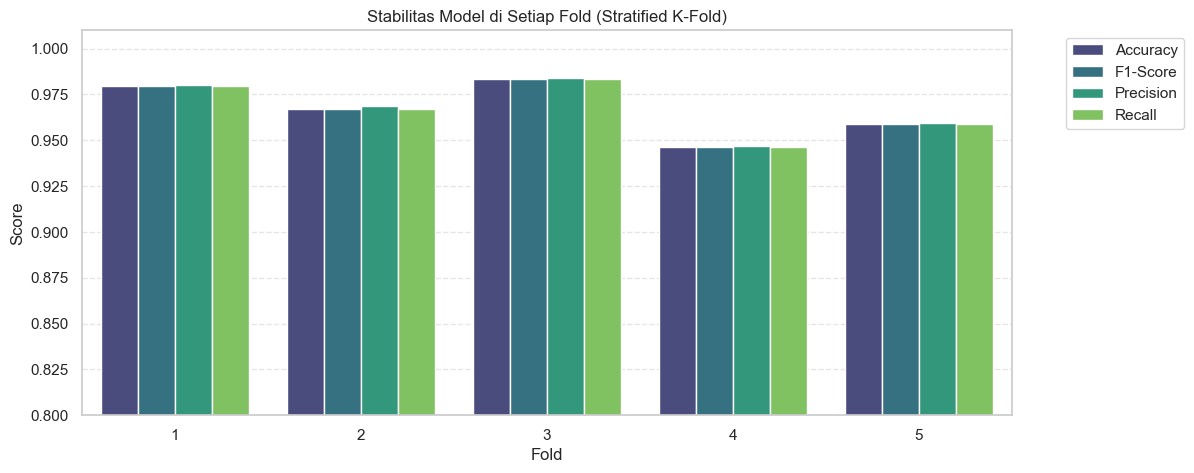

In [4]:
# Buat DataFrame dari hasil fold
metrics_df = pd.DataFrame(fold_scores)

# Hitung Rata-rata
mean_scores = metrics_df.mean()
print("="*40)
print("RATA-RATA PERFORMA MODEL (5 Folds):")
print("="*40)
print(mean_scores)
print("="*40)

# Visualisasi Bar Chart
plt.figure(figsize=(12, 5))
metrics_melted = metrics_df.melt(id_vars="Fold", var_name="Metric", value_name="Score")
sns.barplot(data=metrics_melted, x="Fold", y="Score", hue="Metric", palette="viridis")
plt.title("Stabilitas Model di Setiap Fold (Stratified K-Fold)")
plt.ylim(0.8, 1.01) # Zoom agar perbedaan terlihat jelas
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

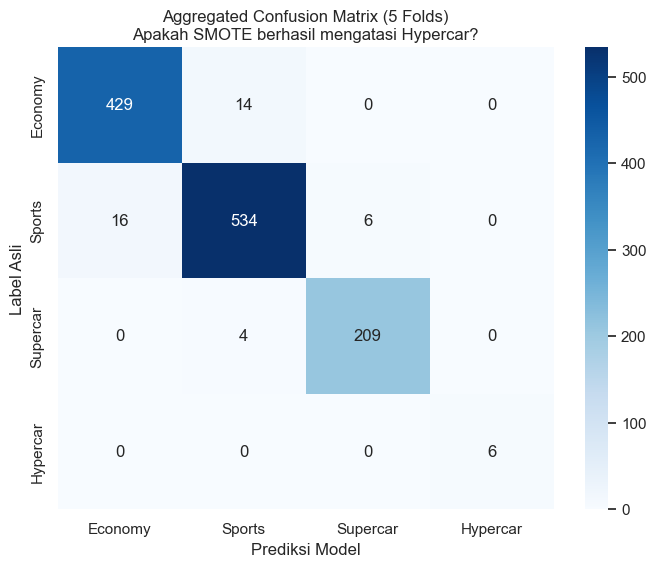

ANALISA HASIL:
1. Diagonal Utama: Jumlah prediksi yang BENAR.
2. Di luar Diagonal: Kesalahan prediksi (Misklasifikasi).

Fokus Evaluasi SMOTE:
Cek baris 'Hypercar'. Jika angkanya mayoritas di diagonal utama,
berarti teknik SMOTE sukses melatih model mengenali kelas minoritas ini.


In [5]:
# Kita ambil Confusion Matrix Total (Penjumlahan dari semua fold)
# Ini memberikan gambaran performa global
total_cm = sum(conf_matrices)

plt.figure(figsize=(8, 6))
sns.heatmap(total_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[cluster_map[i] for i in range(4)],
            yticklabels=[cluster_map[i] for i in range(4)])
plt.title('Aggregated Confusion Matrix (5 Folds)\nApakah SMOTE berhasil mengatasi Hypercar?')
plt.xlabel('Prediksi Model')
plt.ylabel('Label Asli')
plt.show()

# Analisa Tekstual
print("ANALISA HASIL:")
print("1. Diagonal Utama: Jumlah prediksi yang BENAR.")
print("2. Di luar Diagonal: Kesalahan prediksi (Misklasifikasi).")
print("\nFokus Evaluasi SMOTE:")
print("Cek baris 'Hypercar'. Jika angkanya mayoritas di diagonal utama,")
print("berarti teknik SMOTE sukses melatih model mengenali kelas minoritas ini.")

# Minigame

In [10]:

def predict_new_car(car_data):
    """
    Menerima dictionary data mobil baru, membersihkan, dan memprediksi kelasnya.
    """
    # 1. Buat DataFrame dari input dictionary
    new_df = pd.DataFrame([car_data])
    
    # 2. Cleaning (Sama seperti proses training sebelumnya)
    # Pastikan fungsi clean_currency dan clean_unit sudah ada di memori (dari Cell 2)
    new_df['Cars Prices'] = new_df['Cars Prices'].apply(clean_currency)
    new_df['CC/Battery Capacity'] = new_df['CC/Battery Capacity'].apply(clean_unit)
    new_df['HorsePower'] = new_df['HorsePower'].apply(clean_unit)
    new_df['Total Speed'] = new_df['Total Speed'].apply(clean_unit)
    new_df['Performance(0 - 100 )KM/H'] = new_df['Performance(0 - 100 )KM/H'].apply(clean_unit)
    new_df['Torque'] = new_df['Torque'].apply(clean_unit)
    new_df['Seats'] = pd.to_numeric(new_df['Seats'], errors='coerce').fillna(0)
    
    # 3. Pastikan urutan kolom sama persis dengan X saat training
    # Variable 'features' harus sudah terdefinisi di Cell 2
    X_new = new_df[features]
    
    # 4. Lakukan Prediksi menggunakan model yang sudah dilatih
    # Variable 'rf_model' harus sudah terdefinisi di Cell 3
    cluster_id = rf_model.predict(X_new)[0]
    
    # 5. Ambil nama kategori dari mapping
    category_name = cluster_map[cluster_id]
    
    return category_name, new_df

print("Fungsi 'predict_new_car' berhasil dibuat. Sekarang coba jalankan cell test prediksi lagi.")


# Kasus 1: Mobil Keluarga Murah
car_1 = {
    'CC/Battery Capacity': '1500 cc',
    'HorsePower': '120 hp',
    'Total Speed': '180 km/h',
    'Performance(0 - 100 )KM/H': '11.5 sec',
    'Cars Prices': '$25,000',
    'Torque': '150 Nm',
    'Seats': 5
}

# Kasus 2: Supercar Mahal
car_2 = {
    'CC/Battery Capacity': '4000 cc',
    'HorsePower': '700 hp',
    'Total Speed': '340 km/h',
    'Performance(0 - 100 )KM/H': '2.9 sec',
    'Cars Prices': '$350,000',
    'Torque': '800 Nm',
    'Seats': 2
}


print("="*50)
print("HASIL PREDIKSI MOBIL BARU")
print("="*50)

for i, car in enumerate([car_1, car_2, car_3], 1):
    kategori, data_clean = predict_new_car(car)
    print(f"\nMobil {i}:")
    print(f"Spesifikasi: {car['HorsePower']} | {car['Cars Prices']} | {car['Torque']}")
    print(f"PREDIKSI KATEGORI: {kategori}")

Fungsi 'predict_new_car' berhasil dibuat. Sekarang coba jalankan cell test prediksi lagi.
HASIL PREDIKSI MOBIL BARU

Mobil 1:
Spesifikasi: 120 hp | $25,000 | 150 Nm
PREDIKSI KATEGORI: Economy

Mobil 2:
Spesifikasi: 700 hp | $350,000 | 800 Nm
PREDIKSI KATEGORI: Supercar

Mobil 3:
Spesifikasi: 1000 hp | $110,000 | 15000 Nm
PREDIKSI KATEGORI: Hypercar


In [11]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- 1. SETUP WIDGETS (FORMULIR INPUT) ---
style = {'description_width': 'initial'}
layout = widgets.Layout(width='95%')

# Header
header = widgets.HTML("<h2>🚗 Car Classification Minigame</h2><p>Masukkan spesifikasi mobil dan biarkan AI menebak kelasnya!</p>")

# Input Fields (Text Box agar fleksibel menerima angka atau satuan)
w_company = widgets.Text(description="Company Name:", placeholder="e.g. Ferrari", style=style, layout=layout)
w_car_name = widgets.Text(description="Car Name:", placeholder="e.g. F8 Tributo", style=style, layout=layout)
w_engine = widgets.Text(description="Engine:", placeholder="e.g. V8 Twin Turbo", style=style, layout=layout)
w_fuel = widgets.Dropdown(options=['Petrol', 'Diesel', 'Electric', 'Hybrid'], description="Fuel Type:", style=style, layout=layout)

# Numeric Inputs (Using Text widgets to handle units like '$', 'hp', etc. via our cleaner functions)
w_price = widgets.Text(description="Car Price ($):", placeholder="e.g. 250000", value="0", style=style, layout=layout)
w_hp = widgets.Text(description="HorsePower:", placeholder="e.g. 710 hp", value="0", style=style, layout=layout)
w_torque = widgets.Text(description="Torque (Nm):", placeholder="e.g. 770 Nm", value="0", style=style, layout=layout)
w_speed = widgets.Text(description="Total Speed (km/h):", placeholder="e.g. 340 km/h", value="0", style=style, layout=layout)
w_accel = widgets.Text(description="0-100 km/h (sec):", placeholder="e.g. 2.9 sec", value="0", style=style, layout=layout)
w_cc = widgets.Text(description="CC / Battery:", placeholder="e.g. 3900 cc", value="0", style=style, layout=layout)
w_seats = widgets.IntSlider(min=1, max=10, step=1, value=2, description="Seats:", style=style, layout=layout)

# Button & Output
btn_predict = widgets.Button(
    description="🔍 PREDIKSI KATEGORI!",
    button_style='primary', # 'success', 'info', 'warning', 'danger' or ''
    layout=widgets.Layout(width='100%', height='50px'),
    icon='car'
)
out_result = widgets.Output()

# --- 2. LOGIKA GAME ---
def on_predict_click(b):
    with out_result:
        clear_output()
        
        # Ambil data dari widget
        input_data = {
            # Data Metadata (Hanya untuk display)
            'Company': w_company.value,
            'Car Name': w_car_name.value,
            
            # Data Fitur (Digunakan Model)
            'CC/Battery Capacity': w_cc.value,
            'HorsePower': w_hp.value,
            'Total Speed': w_speed.value,
            'Performance(0 - 100 )KM/H': w_accel.value,
            'Cars Prices': w_price.value,
            'Torque': w_torque.value,
            'Seats': w_seats.value
        }
        
        try:
            # Panggil fungsi prediksi yang sudah kita buat sebelumnya
            kategori, _ = predict_new_car(input_data)
            
            # Tentukan warna & emoji berdasarkan hasil
            color_map = {
                'Economy': ('gray', '🛒'),
                'Sports': ('orange', '🏎️'),
                'Supercar': ('red', '🔥'),
                'Hypercar': ('purple', '🚀')
            }
            color, emoji = color_map.get(kategori, ('black', '❓'))
            
            # Tampilkan Hasil dengan HTML Styling
            full_name = f"{input_data['Company']} {input_data['Car Name']}".strip() or "Mobil Misterius"
            
            display(widgets.HTML(f"""
            <div style="background-color: #f0f8ff; padding: 20px; border-radius: 10px; border: 2px solid {color}; text-align: center;">
                <h3 style="color: #333;">Hasil Analisa AI:</h3>
                <h1 style="color: {color}; font-size: 40px; margin: 10px 0;">{emoji} {kategori.upper()} {emoji}</h1>
                <p style="font-size: 16px;">
                    Mobil <b>{full_name}</b> diklasifikasikan sebagai <b>{kategori}</b>.<br>
                    <i>(Berdasarkan kombinasi HP, Harga, dan Performa)</i>
                </p>
            </div>
            """))
            
        except NameError:
            print("❌ Error: Fungsi 'predict_new_car' belum didefinisikan. Jalankan cell sebelumnya dulu!")
        except Exception as e:
            print(f"❌ Terjadi kesalahan: {e}")

btn_predict.on_click(on_predict_click)

# --- 3. TAMPILAN LAYOUT ---
# Susun Grid Layout (2 Kolom)
left_col = widgets.VBox([w_company, w_car_name, w_engine, w_fuel, w_price])
right_col = widgets.VBox([w_hp, w_torque, w_speed, w_accel, w_cc, w_seats])
ui = widgets.VBox([header, widgets.HBox([left_col, right_col]), btn_predict, out_result])

# Tampilkan UI
display(ui)